In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import random

from matplotlib.colors import ListedColormap
from random import choices
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
import warnings
import copy
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

In [3]:
from jupyter_utils import style, mean_std, display_test, display_group_test, scatter_annotate, show_corrtest_mask_corr
from ortogonolize_utils import draw_scatter, draw_corrected_scatter
from ortogonolize_utils import compute_coefficient, compute_ortogonolized_coefficient, compute_ortogonolized_logit

In [4]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/'

## merge data with psychosocial data

In [5]:
df = pd.read_csv(PATH +'rus_merged_psychosocial_data.csv', index_col=0)
df = df[df.index.notnull()]
df.rename(columns={'dep.severity-1': 'dep.severity',
                  'HDRS-17.score-1': 'HDRS-17',
                   'panss-1-td': 'panss_td',
                   'panss-1-total': 'panss_total', 
                   'panss-n-1-total': 'panss_neg', 
                   'panss-o-1-total': 'panss_o',
                   'panss-p-1-total': 'panss_pos', 
                   'sans-1-total': 'sans',
                   'saps-ftd-1-total': 'saps_ftd', 
                   'sops-1-total': 'sops_total', 
                   'sops-c-total': 'sops_c',
                   'sops-d-total': 'sops_d', 
                   'sops-n-total': 'sops_n', 
                   'sops-p-total': 'sops_p'
                  }, inplace=True)
df['index'] = df.index
df.drop_duplicates(inplace=True, subset='index')
df.drop(columns=['index'], inplace=True)

In [6]:
len(df)

176

In [7]:
res_df = pd.read_csv(PATH + 'processed_values/ru_both.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [8]:
len(res_df)

183

In [9]:
dfi = [i.replace('-', '').replace('S', 'PD1') for i in df.index]
df.index = dfi
# res_df.index = [i.replace('S', 'PD1') for i in res_df.index]
rdfi = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]

missing_psy = set(rdfi).difference(set(dfi))
missing_psy

{'PN005', 'PN006', 'PN012', 'PN014', 'PN019', 'PN238', 'PN327'}

In [10]:
missing_psy = [i for i in res_df.index if i.split('_')[0] in missing_psy]
res_df.drop(missing_psy, inplace=True)

In [11]:
len(res_df)

176

In [12]:
missing_text = set(dfi).difference(set(rdfi))
len(missing_text)

0

In [13]:
df.drop(missing_text, inplace=True)

In [14]:
non_start_timepoint = [i for i in res_df.index if i.split('_')[-1] != '1']
res_df.drop(non_start_timepoint, inplace=True)

In [15]:
res_df.loc['PD101_1'].dropna()

TASK                               
adventure  LM         m_bert_cgcoh      0.954746
                      m_bert_gcoh       0.942201
                      m_bert_lcoh       0.873049
                      m_bert_scoh       0.865214
                      m_cgcoh           0.930773
                                         ...    
sportsman  syntactic  max_sent_len     20.000000
                      mean_sent_len     8.500000
                      min_sent_len      2.000000
                      n_sents          12.000000
                      std_sent_len      4.425306
Name: PD101_1, Length: 156, dtype: float64

In [16]:
rdfi_filtered = [i.split('_')[0].replace('S', 'PD1') for i in res_df.index]
res_df.index = rdfi_filtered

## psychosocial statistics

In [17]:
def fill_diagnosis_type(row):
    dt = row['diagnosis.type']
    if not pd.isna(dt):
        return dt
    else:
        if not pd.isna(row['td.severity']):
            return 'control_psy'
        else:
            return 'control'

In [18]:
df['diagnosis.type'] = df.apply(fill_diagnosis_type, axis=1)

In [19]:
sz = df[df['diagnosis.type'] == 'sz']
dep = df[df['diagnosis.type'] == 'dep']
control = df[df['diagnosis.group'] == 'control']
control_psy = df[df['diagnosis.type'] == 'control_psy']

In [20]:
df.columns

Index(['age', 'dep.scale', 'dep.severity', 'group.code', 'diagnosis.group',
       'diagnosis.type', 'diagnosis_code', 'diagnosis_eng', 'diagnosis_rus',
       'education.level.code', 'education.level.eng', 'education.years',
       'exacerbation', 'HDRS-17', 'longitudinal', 'panss_td', 'panss_total',
       'panss_neg', 'panss_o', 'panss_pos', 'rehospitalization', 'sans',
       'saps_ftd', 'sex', 'sops_total', 'sops_c', 'sops_d', 'sops_n', 'sops_p',
       'td.scales', 'td.severity'],
      dtype='object')

In [21]:
len(df)

176

In [22]:
df['diagnosis.group'].value_counts()

control    127
patient     49
Name: diagnosis.group, dtype: int64

In [23]:
df['diagnosis.type'].value_counts()

control        86
control_psy    41
sz             31
dep            18
Name: diagnosis.type, dtype: int64

In [24]:
df['dep.scale'].value_counts()

HDRS    51
QIDS    39
Name: dep.scale, dtype: int64

In [25]:
df['td.scales'].value_counts()

SCL-90-R    39
PANSS       28
SAPS        21
Name: td.scales, dtype: int64

In [26]:
print(df.groupby('diagnosis.type')[['diagnosis_code', 'diagnosis_eng']].value_counts().to_csv(sep='\t'))

diagnosis.type	diagnosis_code	diagnosis_eng	0
dep	F31	bipolar.affective.disorder	6
dep	F60.31	borderline.personality.disorder	3
dep	F31.4	bipolar.affective.disorder.severe	2
dep	F31.5	bipolar.affective.disorder.severe.psychotic	2
dep	F33	recurrent.depressive.disorder	2
dep	F32.1	depressive.episode.moderate	1
dep	F33.3	recurrent.depressive.disorder.severe.psychotic	1
dep	F60	personality.disorder	1
sz	F20	schizophrenia	20
sz	F25	schizoaffective.disorder	8
sz	F21	schizotypal.disorder	2
sz	F21.3	schizotypal.disorder.pseudoneurotic.schizophrenia	1



### select target cols

In [27]:
target_cols = ['sex', 'age', 'education.years', 
               'diagnosis.group', 'diagnosis.type',
               'dep.severity', 'td.severity']

In [28]:
# panss_cols = [col for col in df.columns if col.startswith('panss')]
panss_cols = ['panss_td', 'panss_total', 'panss_neg', 'panss_pos', 'panss_o']
sans_cols = [col for col in df.columns if col.startswith('sans')]
saps_cols = [col for col in df.columns if col.startswith('saps')]
sops_cols = [col for col in df.columns if col.startswith('sops')]

In [59]:
numeric_target = ['education.years','dep.severity','td.severity'] + panss_cols

In [29]:
sz.count()[sz.count() > 0]

age                     31
dep.scale               31
dep.severity            31
group.code               3
diagnosis.group         31
diagnosis.type          31
diagnosis_code          31
diagnosis_eng           31
diagnosis_rus            3
education.level.code     3
education.level.eng     31
education.years         31
exacerbation             3
HDRS-17                 21
longitudinal             3
panss_td                29
panss_total             29
panss_neg               29
panss_o                 29
panss_pos               29
rehospitalization        3
sans                     3
saps_ftd                 3
sex                     31
sops_c                   1
sops_d                   1
sops_n                   1
sops_p                   1
td.scales               31
td.severity             31
dtype: int64

In [30]:
dep.count()[dep.count() > 0]

age                     18
dep.scale               18
dep.severity            18
group.code              18
diagnosis.group         18
diagnosis.type          18
diagnosis_code          18
diagnosis_eng           18
diagnosis_rus           18
education.level.code    18
education.level.eng     18
education.years         18
exacerbation            16
HDRS-17                 18
longitudinal            11
panss_td                12
panss_total             13
panss_neg               13
panss_o                 13
panss_pos               13
rehospitalization       16
sans                    17
saps_ftd                18
sex                     18
sops_c                   8
sops_d                   8
sops_n                   8
sops_p                   8
td.scales               18
td.severity             18
dtype: int64

In [31]:
sz['sex'].value_counts()

female    25
male       6
Name: sex, dtype: int64

In [32]:
mean_std(sz, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,27.13 (7.14),13.32 (2.41),0.58 (0.85),0.84 (0.73),10.03 (3.74),69.79 (16.13),22.93 (8.59),15.9 (4.92),30.97 (8.42)


In [33]:
mean_std(sz, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
sex,,,,,,,,,
female,27.8 (7.53),13.56 (2.48),0.72 (0.89),0.8 (0.76),9.43 (3.62),69.13 (15.38),22.52 (7.79),15.3 (4.91),31.3 (9.08)
male,24.33 (4.72),12.33 (1.97),0.0 (0.0),1.0 (0.63),12.33 (3.56),72.33 (20.16),24.5 (11.93),18.17 (4.67),29.67 (5.65)


In [34]:
dep['sex'].value_counts()

female    18
Name: sex, dtype: int64

In [35]:
mean_std(dep, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,20.89 (3.71),12.67 (1.94),0.56 (0.62),0.06 (0.24),4.42 (0.9),37.92 (5.89),8.31 (1.97),8.46 (1.94),21.15 (3.58)


In [36]:
dep['panss_o'].count()

13

In [37]:
control['sex'].value_counts()

female    89
male      38
Name: sex, dtype: int64

In [38]:
mean_std(control, target_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity
value,40.42 (19.15),15.55 (2.54),0.0 (0.0),0.0 (0.0)


In [39]:
mean_std(control, target_cols, 'sex')

,age,education.years,dep.severity,td.severity
sex,,,,
female,38.97 (18.87),15.25 (2.33),0.0 (0.0),0.0 (0.0)
male,43.92 (19.63),16.24 (2.88),0.0 (0.0),0.0 (0.0)


In [40]:
control_psy['sex'].value_counts()

female    31
male      10
Name: sex, dtype: int64

In [41]:
mean_std(control_psy, target_cols + panss_cols)

/Users/galina.ryazanskaya/Downloads/thesis?/code?/jupyter_utils.py:115: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  s_mean, s_std = data.mean().round(2), data.std().round(2)


,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
value,27.62 (11.16),15.05 (2.07),0.0 (0.0),0.0 (0.0),4.36 (1.0),30.77 (1.54),7.23 (0.53),7.23 (0.61),16.32 (0.95)


In [42]:
mean_std(control_psy, target_cols + panss_cols, 'sex')

,age,education.years,dep.severity,td.severity,panss_td,panss_total,panss_neg,panss_pos,panss_o
sex,,,,,,,,,
female,27.19 (10.59),15.23 (1.67),0.0 (0.0),0.0 (0.0),4.4 (1.05),30.85 (1.6),7.25 (0.55),7.25 (0.64),16.35 (0.99)
male,29.11 (13.57),14.5 (3.06),0.0 (0.0),0.0 (0.0),4.0 (0.0),30.0 (0.0),7.0 (0.0),7.0 (0.0),16.0 (0.0)


In [43]:
control.groupby('sex')['panss_total'].count()

sex
female    20
male       2
Name: panss_total, dtype: int64

In [44]:
control_psy.count()[control_psy.count() > 0]

age                    40
dep.scale              41
dep.severity           41
diagnosis.group        41
diagnosis.type         41
education.level.eng    39
education.years        41
HDRS-17                22
panss_td               22
panss_total            22
panss_neg              22
panss_o                22
panss_pos              22
sex                    41
td.scales              39
td.severity            41
dtype: int64

In [45]:
df.dropna(axis=0, thresh=30).iloc[0]

age                                      18.0
dep.scale                                HDRS
dep.severity                              1.0
group.code                                2.0
diagnosis.group                       patient
diagnosis.type                             sz
diagnosis_code                            F21
diagnosis_eng            schizotypal.disorder
diagnosis_rus                  Шизотипическое
education.level.code                      1.0
education.level.eng     vocational.unfinished
education.years                          11.0
exacerbation                              1.0
HDRS-17                                   9.0
longitudinal                              1.0
panss_td                                  4.0
panss_total                              39.0
panss_neg                                 9.0
panss_o                                  23.0
panss_pos                                 7.0
rehospitalization                         0.0
sans                              

### test for differences

age

In [46]:
stats.ttest_ind(control['age'], sz['age'], nan_policy='omit')

Ttest_indResult(statistic=3.792016852642703, pvalue=0.00021365411299027322)

In [47]:
stats.ttest_ind(control_psy['age'], sz['age'], nan_policy='omit')

Ttest_indResult(statistic=0.2153674324904064, pvalue=0.8301161925857043)

In [48]:
stats.ttest_ind(control_psy['age'], dep['age'], nan_policy='omit')

Ttest_indResult(statistic=2.4881519657788718, pvalue=0.01584262497225197)

eduaction years

In [49]:
stats.ttest_ind(control['education.years'], sz['education.years'], nan_policy='omit')

Ttest_indResult(statistic=4.413764611185695, pvalue=1.8946847417844383e-05)

In [50]:
stats.ttest_ind(control_psy['education.years'], sz['education.years'], nan_policy='omit')

Ttest_indResult(statistic=3.258999809255893, pvalue=0.0017271856550259523)

In [51]:
stats.ttest_ind(control_psy['education.years'], dep['education.years'], nan_policy='omit')

Ttest_indResult(statistic=4.14129240861394, pvalue=0.00011546243076058939)

sex

In [52]:
# display ttest

In [53]:
a = 0.05

In [56]:
s_t_sex, res_t_sex = display_group_test(df, numeric_target, 'sex', stats.ttest_ind, stat_name='t', alpha=a)
s_t_sex

,t,p,sig,abs_t
panss_td,2.691122,0.009176,True,2.691122
education.years,2.445263,0.015477,True,2.445263
panss_pos,2.312633,0.024076,True,2.312633
dep.severity,-2.227480,0.028466,True,2.227480
panss_neg,1.776291,0.080591,False,1.776291
panss_total,1.689565,0.096134,False,1.689565
panss_o,0.785030,0.435425,False,0.785030
td.severity,0.559319,0.577365,False,0.559319


### correlation between target variables

In [ ]:
# display corr test

In [61]:
x, y = display_test(df, numeric_target, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
education.years,0.411685,0.0,True,0.411685
panss_neg,0.383708,0.001749,True,0.383708


In [63]:
x, y = display_test(df, numeric_target, 'education.years', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
panss_o,-0.407709,0.000826,True,0.407709
dep.severity,-0.31841,0.002224,True,0.31841


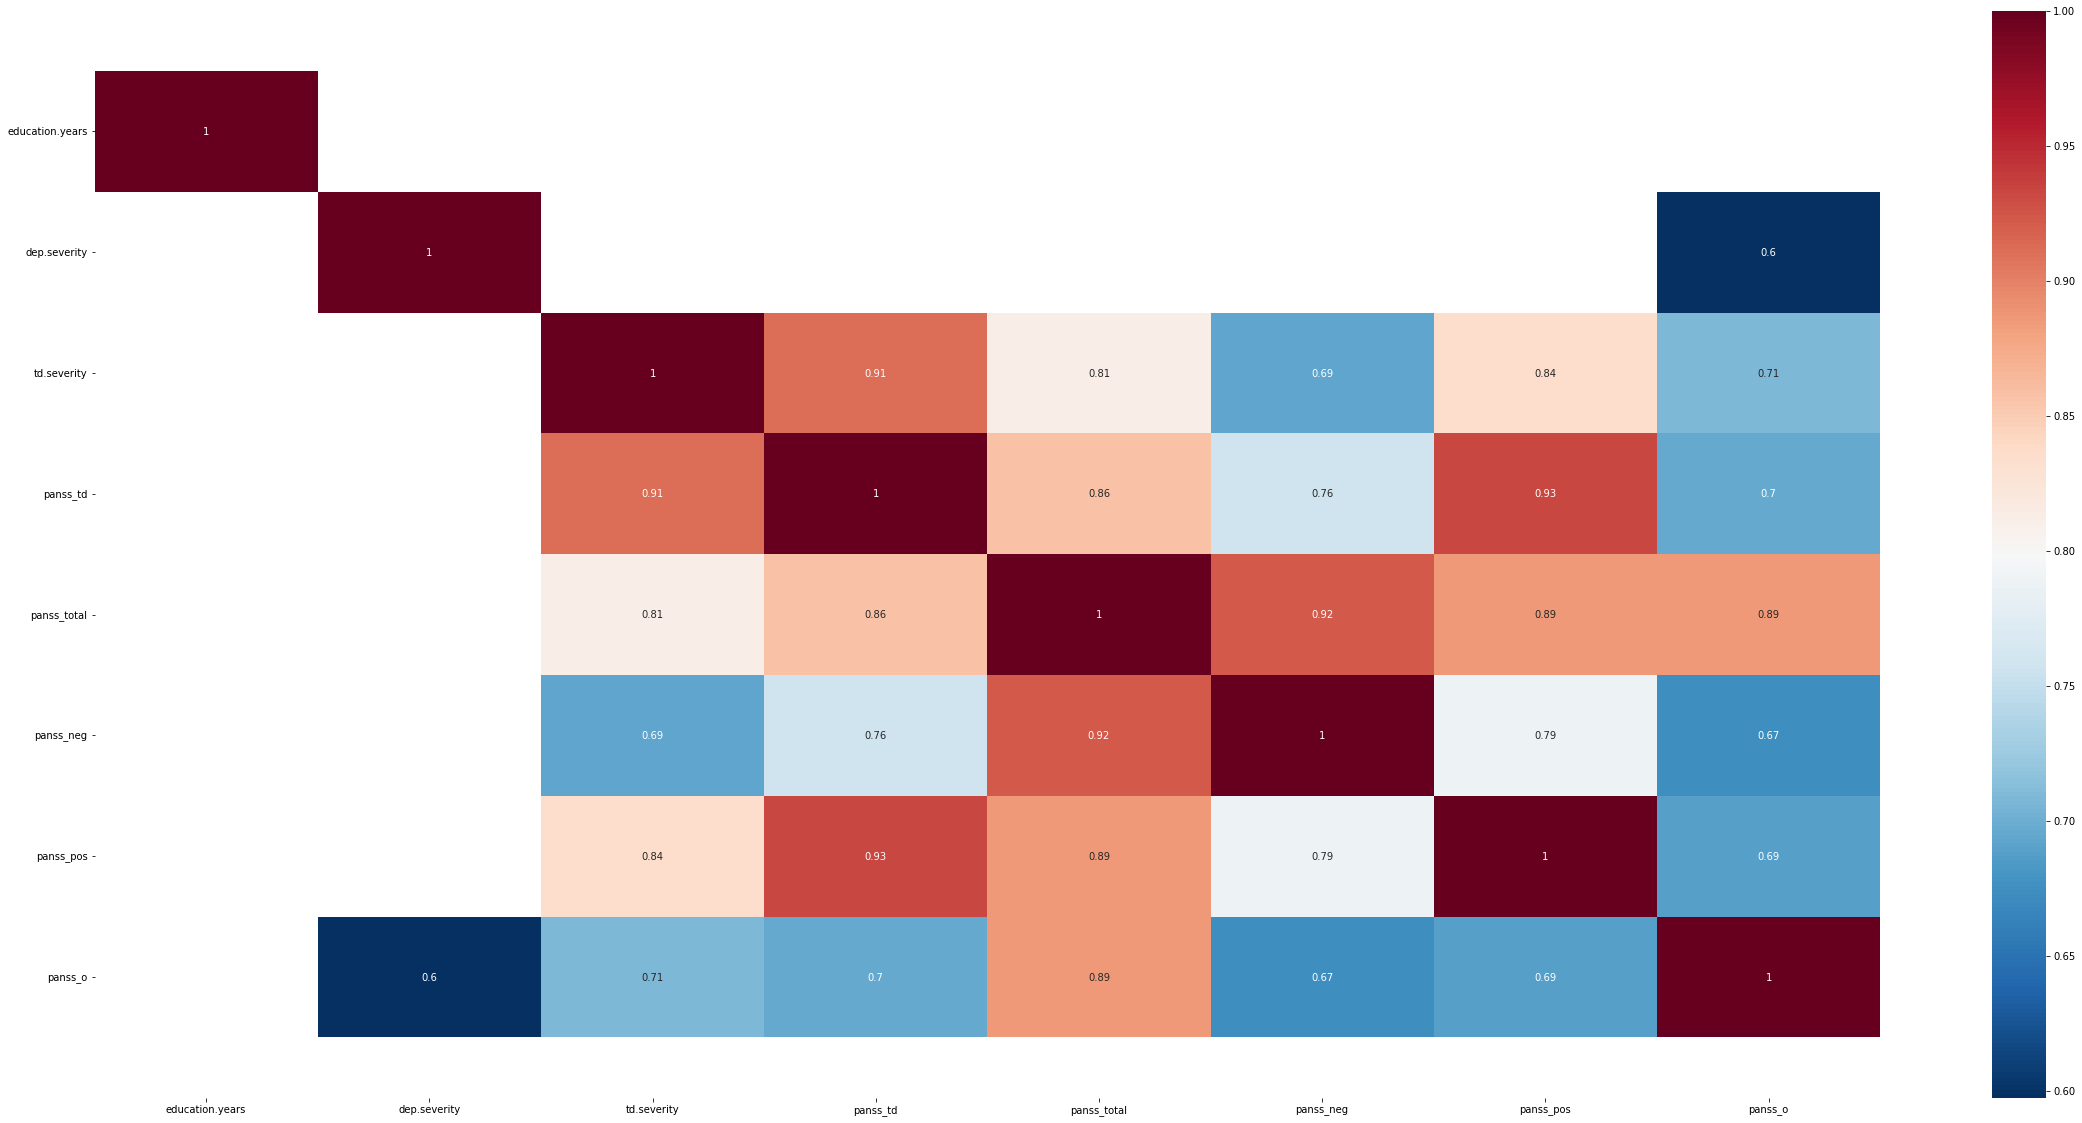

In [65]:
target_corr_res = show_corrtest_mask_corr(df[numeric_target])

## scores

In [ ]:
res_df

## features of raw texts

In [ ]:
raw = pd.read_csv(PATH+'rus_transcript_lex_by_task_with_dots.tsv', sep='\t', index_col=0)

In [ ]:
ids_to_drop = [i for i in raw.index if i.split('_')[0] not in res_df.index]

In [ ]:
raw.drop(index=ids_to_drop, inplace=True)

In [ ]:
raw.index = [i.split('_')[0] for i in raw.index]

In [ ]:
raw.isna().sum(axis=0).sum()

In [ ]:
raw.applymap(lambda x: len(x.split('.')) if not pd.isna(x) else np.nan).mean(axis=1).hist()

## look at tasks

In [ ]:
task_available = raw.applymap(lambda x: 1 if not pd.isna(x) else x)

In [ ]:
len(task_available)

In [ ]:
task_available['diagnosis.type'] = df['diagnosis.type']

In [ ]:
task_available.count()

In [ ]:
task_available.groupby('diagnosis.type').count()

In [ ]:
task_available.groupby('diagnosis.type').count()[task_available.groupby('diagnosis.type').count() > 0].dropna(axis=1)

In [ ]:
def drop_person(row):
    for task in ('adventure', 'chair','present','sportsman'):
        if not pd.isna(row[task]):
            return False
    return True

In [ ]:
ids_with_at_least_one_task = task_available[~task_available.apply(drop_person, axis=1)].index

In [ ]:
df = df.loc[ids_with_at_least_one_task]

In [ ]:
res_df = res_df.loc[ids_with_at_least_one_task, ['adventure', 'chair', 'present', 'sportsman']]

In [ ]:
def task_data(df, task, keep_target=True, fill_synt=True):
    subset = df[task].dropna(axis=0, how='all')
    if fill_synt:
        subset['syntactic'] = subset['syntactic'].fillna(0.0)
    if keep_target:
        subset = pd.concat([subset, df['target'].loc[subset.index]], axis=1)
    return subset

In [ ]:
def aplly_to_all_tasks(df, f, tasks=('adventure', 'chair','present','sportsman'), to_df=True, *args, **kwargs):
    res = {}
    for task in tasks:
        data = task_data(df, task)
        res[task] = f(data, *args, **kwargs)
    return pd.DataFrame(res)

### merge psychoscial data to scores

In [ ]:
merge_df = res_df.copy()
for col in target_cols + panss_cols:
    merge_df[('target', 'target', col)] = df[col]

In [ ]:
cols_LM = [col for col in res_df['chair'] if col[0] == 'LM']
cols_synt = [col for col in res_df['chair'] if col[0] == 'syntactic']
cols_lex = [col for col in res_df['chair'] if col[0] == 'lexical']
cols_graph = [col for col in res_df['chair'] if col[0] == 'graph']

In [ ]:
 = res_df['chair'].columns

In [ ]:
merge_df['chair'].dropna(axis=0, how='all')

In [ ]:
def corr(df, target):
    return df[~pd.isnull(df[target])].corr()[target]

In [ ]:
def corr_thresh(df, target, thresh=0.3, drop_target=True):
    corr_tgt = corr(df, target)
    if drop_target:
        corr_tgt.drop('target', inplace=True)
    return corr_tgt[abs(corr_tgt) >= thresh]

In [ ]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'age')))

In [ ]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'education.years')))

In [ ]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_pos')))

In [ ]:
style(aplly_to_all_tasks(merge_df, corr_thresh, target=('target', 'panss_neg')))